# Theory Picchi 2021

In this notebook, I reproduce the Theory in *Motion of a confined bubble in a shear-thinning liquid*, by D. Picchi, published in JFM in 2021. 

https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/motion-of-a-confined-bubble-in-a-shearthinning-liquid/47C8A583F6E080925C7D6A63347D6AB9

In [98]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from myimagelib.myImageLib import bestcolor

## 1 Define the problem

Before deriving the final equation from scratch, I want to first start with the numerical solution part, by solving

$$
\frac{d^3\eta}{d\xi^3} = \frac{\eta - 1}{\eta^3}, \tag{1}
$$

which describes the surface profile of a thin film created by fluid flow, between an air bubble and a solid wall. The thin film surface profile will be like the following schematic. This theoretical model could be useful for understanding the fringe pattern near pickled beet root.

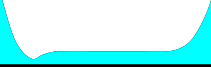

The front and rear profiles are obtained by solving Eqn.1, to different directions using different boundary conditions. In the following, we will solve for front and rear profiles separately.

## 2 Front profile

The boundary condition for the front side is given by considering when $\xi > 0$, the exponential term dominates:

$$
\eta \approx 1 + a e^{\xi}. \tag{2}
$$

This leads to the following set of boundary conditions:

$$
\eta(0) = 1, \; \frac{d\eta}{d\xi}\bigg\rvert_0 = a, \; \frac{d^2\eta}{d\xi^2}\bigg\rvert_0 = a, \; \frac{d^3\eta}{d\xi^3}\bigg\rvert_0 = a. \tag{3}
$$

*The value of $a$ only changes the location of the origin.* Here, we set $a=10^{-4}$ and integrate Eqn.1 to $+\infty$.

### 2.1 Solve with `scipy`

In [74]:
# use `odeint` to solve the equation
a = 1e-5

# define the differential equation
def ode(y, t):
    eta, F, S = y
    dydt = F, S, (eta-1)/eta**3
    return dydt

# set initial conditions
y0 = [1, a, a]

# discretize the space
t = np.linspace(0, 100, 1001)

# solve the equation
sol = odeint(ode, y0, t)

In [71]:
sol.shape

(101, 3)

(0.0, 16.0)

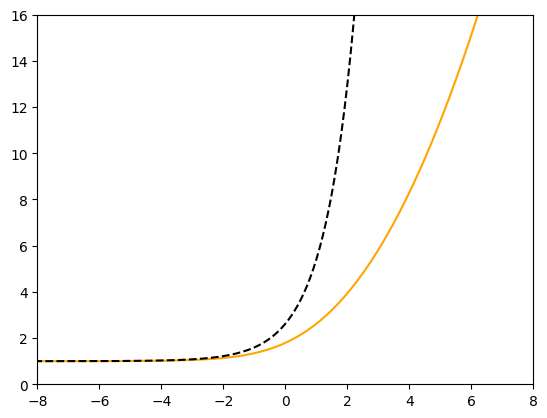

In [75]:
# numerical solution
plt.plot(t-12, sol[:, 0], color="orange")
# exponential approximation
plt.plot(t-12, 1 + a*np.exp(t), color="black", ls="--")
# parabolic approximation

plt.xlim([-8, 8])
plt.ylim([0, 16])

The original result of intergration from $\xi=0$ is different from the result shown in Fig.3(a). The above result is obtained by translating the original one horizontally by -12. 

### 2.2 Self-made discretization scheme

By definition, we can discretize the 3rd order derivative $d^3\eta/d\xi^3$ as

$$
\frac{d^3\eta}{d\xi^3} = \frac{\eta_{i+3} - 3\eta_{i+2} + 3\eta_{i+1} - \eta_i}{\Delta\xi^3}.
$$

With this, we can write Eqn.1 as a number sequence which can be iterated

$$
\frac{\eta_{i+3} - 3\eta_{i+2} + 3\eta_{i+1} - \eta_i}{\Delta\xi^3} = \frac{\eta_i - 1}{\eta_i^3},
$$

rearrange we get

$$
\eta_{i+3} = \frac{\eta_i - 1}{\eta_i^3} \Delta\xi^3 + 3\eta_{i+2} - 3\eta_{i+1} + \eta_i. \tag{4}
$$

We can discretize $\eta(\xi)$ in the space of $\xi$ into $N$ pieces: $\{\eta_1, \eta_2, \dots, \eta_N\}$. From the boundary conditions (Eqn.2), we obtain:

$$
\eta_1 = 1, \; \eta_2 = a\Delta\xi, \; \eta_3 = a\Delta\xi^2 + 2a\Delta\xi, \; \eta_4 = 
$$

With these, we can get the sequence rolling according to Eqn.4.

In [65]:
# discretize \xi space
N = 1001
tmin = 0
tmax = 20
t = np.linspace(tmin, tmax, N)
# preallocate \eta
eta = np.zeros((N, 1))

a = 1e-5
dt = (tmax - tmin) / (N - 1)
# input boundary conditions
eta[0] = 1
eta[1] = 1 + a * dt
eta[2] = 1 + a * dt**2 + 2 * a * dt

# iterate
for i in range(3, N):
    eta[i] = (eta[i-3] - 1) / eta[i-3]**3 * dt**3 + 3 * eta[i-1] - 3 * eta[i-2]  + eta[i-3]

(0.0, 16.0)

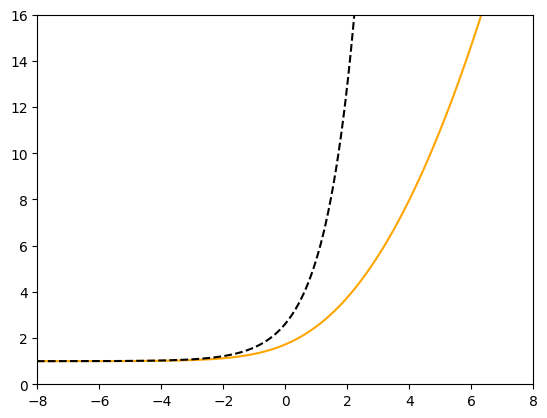

In [66]:
# numerical solution
plt.plot(t-12, eta[:, 0], color="orange")
# exponential approximation
plt.plot(t-12, 1 + a*np.exp(t), color="black", ls="--")
# parabolic approximation

plt.xlim([-8, 8])
plt.ylim([0, 16])

**Remark:** the two methods gives similar results as long as we discretize the space sufficiently.

### 2.3 Parabolic approximation

When $\eta \gg 1$, 
$$
\frac{d^3\eta}{d\xi^3} = \frac{\eta - 1}{\eta^3} \approx 0.
$$

This gives a parabolic solution, 

$$
\eta = \frac{P}{2}\xi^2 + W\xi + Z,
$$

which should match the numerical solution when $\eta \gg 1$. The coefficients $P,W,Z$ are determined from the numerical solution. In this section, we determine these coefficients.

#### 2.3.1 $P$

$P$ is the curvature of the parabolic curve. To match the parabolic curve with the numerical solution, we need to first guarantee that the curvature of the numerical solution at $\eta\gg 1$ matches that of the parabolic curve, i.e. 

$$
P = \frac{d^2\eta}{d\xi^2}\bigg\rvert_{\xi\to +\infty}
$$ 

We start by computing the curvature of the numerical solution numerically.

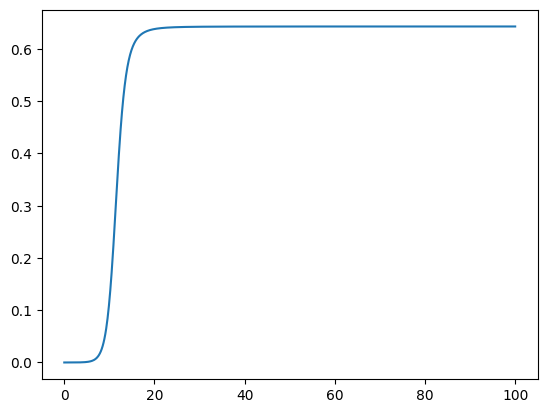

In [76]:
# plot the second derivative
plt.plot(t, sol[:, 2])

In [77]:
sol[-1, 2]

0.6430352551657182

We get $P=0.643$.

#### 2.3.2 $W$ and $Z$

This is a minimization problem:

$$
\argmin_{W,Z} \sum_{\xi\in[20,100]} \frac{P}{2} \xi^2 + W\xi + Z - \eta (\xi)
$$

Note that the range $[20, 100]$ is roughly the range where $d^2\eta/d\xi^2$ is a constant.

In [81]:
from scipy.optimize import minimize

def tomin(x, xi, eta):
    P = 0.643
    obj = ((P/2 * xi**2 + x[0] * xi + x[1] - eta)**2).sum()
    return obj

In [89]:
minsol = minimize(tomin, (0.1, 1), args=(t[t>20], sol[t>20,0]))

In [90]:
minsol

      fun: 0.11772546626771654
 hess_inv: array([[ 1.17187679e-06, -7.03712042e-05],
       [-7.03712042e-05,  4.85079081e-03]])
      jac: array([1.77975744e-06, 1.86264515e-09])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 7
     njev: 10
   status: 0
  success: True
        x: array([-7.56317079, 47.23491531])

In [91]:
W, Z = minsol.x

In [92]:
P = 0.643

Text(0, 0.5, '$\\eta$')

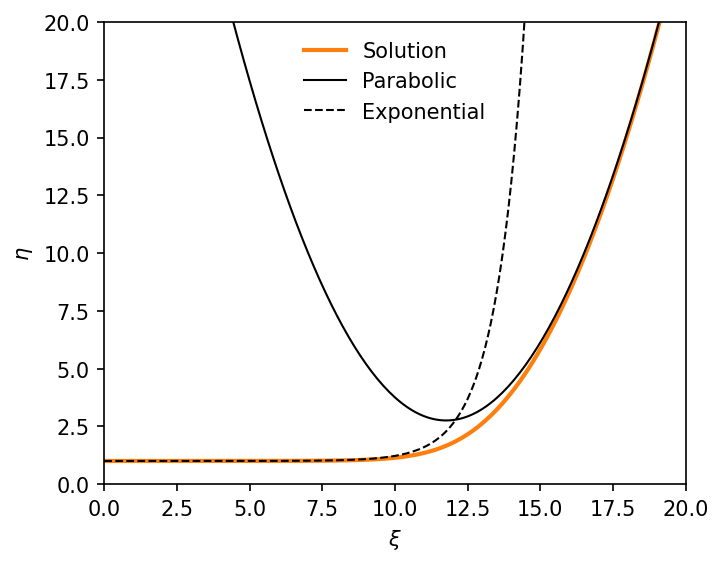

In [105]:
# plot together
plt.figure(figsize=(5,4), dpi=150)
plt.plot(t, sol[:,0], color=bestcolor(1), lw=2, label="Solution")
plt.plot(t, P/2*t**2+W*t+Z, color="black", lw=1, label="Parabolic")
plt.plot(t, 1 + a*np.exp(t), color="black", ls="--", lw=1, label="Exponential")
plt.xlim([0, 20])
plt.ylim([0, 20])
plt.legend(frameon=False)
plt.xlabel("$\\xi$")
plt.ylabel("$\\eta$")

## 3 Rear profile



In this section, we solve for the rear profile. To obtain the boundary condition at $\xi=0$, we approximate that for negative $\xi$, the exponential term can be neglected. This results in

$$
\eta \approx 1 + be^{-\xi/2} \cos\left( \frac{\sqrt 3}{2} \xi \right) + ce^{-\xi/2} \sin\left( \frac{\sqrt 3}{2} \xi \right),
$$

when $\eta \approx 1$. Choosing $\xi=0$ we get the following boundary conditions

$$
\eta (0) = 1 + b, \; \frac{d\eta}{d\xi}\bigg\rvert_0 = c\frac{\sqrt 3}{2} - \frac{b}{2}, \;
\frac{d^2\eta}{d\xi^2}\bigg\rvert_0 = - \frac{b}{2} - c\frac{\sqrt 3}{2} , \;
\frac{d^3\eta}{d\xi^3}\bigg\rvert_0 = b.
$$

### 3.1 Compute with arbitrary $c$

We can start the integration by setting arbitrarily $b=10^{-4}$ and $c=1$. But note that $c$ influences the curvature at $\xi\to -\infty$, so we need to eventually adjust $c$, so that the curvature at $\xi\to -\infty$ matches that at $\xi\to\infty$:

$$
\frac{d^2\eta}{d\xi^2}\bigg\rvert_{\xi\to -\infty} = \frac{d^2\eta}{d\xi^2}\bigg\rvert_{\xi\to +\infty}.
$$

In [106]:
b = 1e-4
c = 1
t = np.linspace(0, -100, 1001)

In [108]:
y0 = [1+b, c*3**0.5/2-b/2, -b/2-c*3**0.5/2]
# solve the equation
sol_neg = odeint(ode, y0, t)

Text(0, 0.5, '$\\eta$')

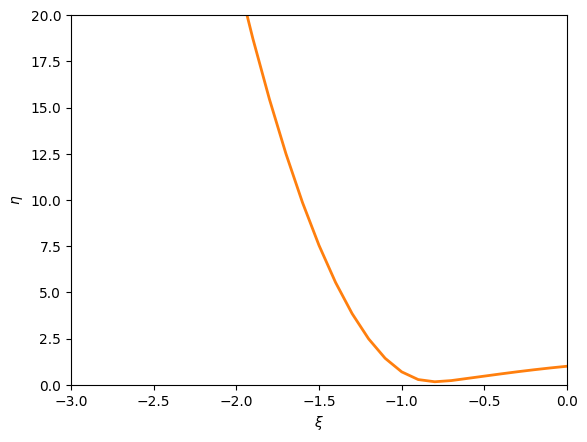

In [118]:
plt.plot(t, sol_neg[:,0], color=bestcolor(1), lw=2)
plt.xlim([-3, 0])
plt.ylim([0, 20])
plt.xlabel("$\\xi$")
plt.ylabel("$\\eta$")

The dimple is already there. Now, let's check the curvature.

In [120]:
sol_neg[-1, 2]

31.715638552264245

### 3.2 Match curvature to get $c$

Clearly, it does not match the front end curvature 0.643. So now we are on the search for the $c$ value that makes the match! The method is naive: try many values.

Text(0, 0.5, '$\\xi\\to -\\infty$ curvature')

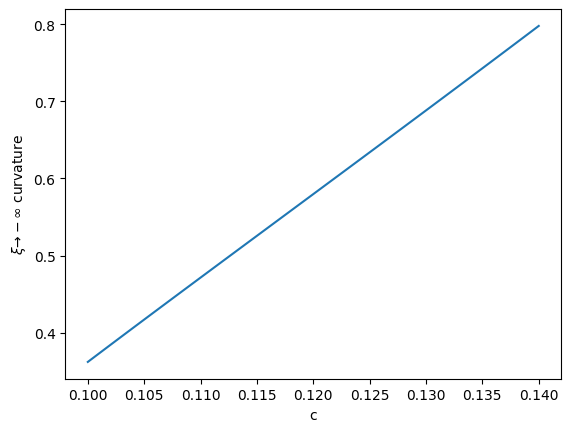

In [126]:
c_list = np.linspace(0.1, .14)
curv_list = []
for c in c_list:
    y0 = [1+b, c*3**0.5/2-b/2, -b/2-c*3**0.5/2]
    # solve the equation
    sol_neg = odeint(ode, y0, t)
    curv_list.append(sol_neg[-1, 2])
plt.plot(c_list, curv_list)
plt.xlabel("c")
plt.ylabel("$\\xi\\to -\infty$ curvature")

In [129]:
c_list[np.array(curv_list)>0.643][0]

0.12612244897959185

So we take $c=0.126$.

In [132]:
c = 0.126
y0 = [1+b, c*3**0.5/2-b/2, -b/2-c*3**0.5/2]
# solve the equation
sol_neg = odeint(ode, y0, t)

Text(0, 0.5, '$\\eta$')

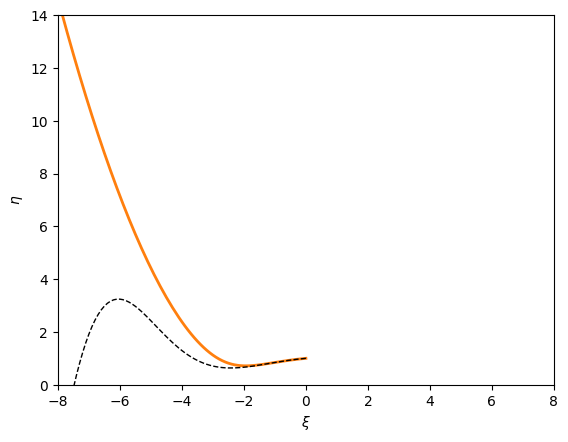

In [142]:
plt.plot(t, sol_neg[:,0], color=bestcolor(1), lw=2)
plt.plot(t, 1+np.exp(-t/2)*(b*np.cos(3**0.5/2*t) + c*np.sin(3**0.5/2*t)), ls="--", lw=1, color="black")
plt.xlim([-8, 8])
plt.ylim([0, 14])
plt.xlabel("$\\xi$")
plt.ylabel("$\\eta$")

### 3.3 Match the parabolic solution

Just need to fit for $W$ and $Z$ using the same procedure in section 2.3.

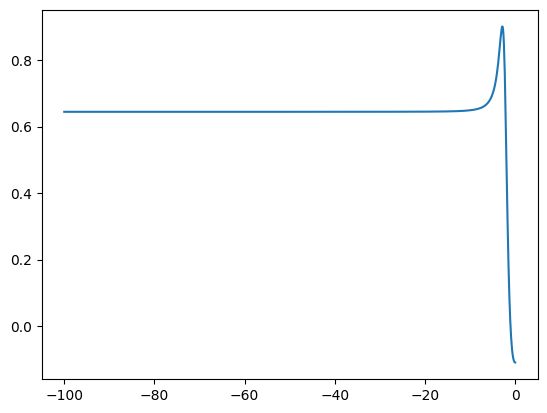

In [143]:
plt.plot(t, sol_neg[:,2])

In [180]:
minsol = minimize(tomin, (-0.1, -0.1), args=(t[(t<-5) & (t>-20)], sol_neg[(t<-5) & (t>-20),0]))

In [181]:
minsol

      fun: 0.2853505012235803
 hess_inv: array([[0.00018139, 0.00226737],
       [0.00226737, 0.03169781]])
      jac: array([ 3.40864062e-06, -2.16066837e-07])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([ 0.72178448, -0.1612958 ])

In [182]:
W, Z = minsol.x

Text(0, 0.5, '$\\eta$')

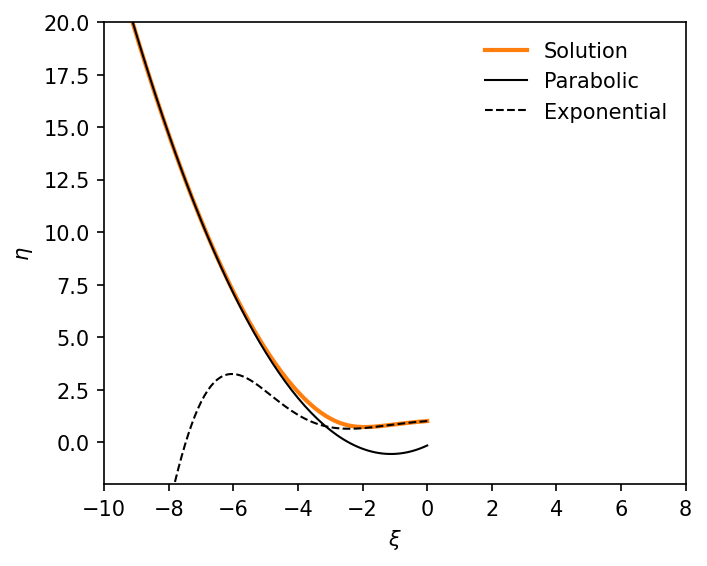

In [183]:
# plot together
plt.figure(figsize=(5,4), dpi=150)
plt.plot(t, sol_neg[:,0], color=bestcolor(1), lw=2, label="Solution")
plt.plot(t, P/2*t**2+W*t+Z, color="black", lw=1, label="Parabolic")
plt.plot(t, 1+np.exp(-t/2)*(b*np.cos(3**0.5/2*t) + c*np.sin(3**0.5/2*t)), color="black", ls="--", lw=1, label="Exponential")
plt.xlim([-10, 8])
plt.ylim([-2, 20])
plt.legend(frameon=False)
plt.xlabel("$\\xi$")
plt.ylabel("$\\eta$")